In [1]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class GaborLayer(Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), activation=None, **kwargs):
        super(GaborLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = activation

    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.kernels_real = self.add_weight(shape=(self.kernel_size[0], self.kernel_size[1], input_channels, self.filters),
                                            initializer='glorot_uniform', trainable=True)
        self.kernels_imag = self.add_weight(shape=(self.kernel_size[0], self.kernel_size[1], input_channels, self.filters),
                                            initializer='glorot_uniform', trainable=True)
        self.built = True

    def call(self, inputs):
        # Perform convolution with complex Gabor filters
        conv_real = K.conv2d(inputs, self.kernels_real, strides=self.strides, padding='valid')
        conv_imag = K.conv2d(inputs, self.kernels_imag, strides=self.strides, padding='valid')

        # Combine real and imaginary parts
        output = K.sqrt(K.square(conv_real) + K.square(conv_imag))

        if self.activation is not None:
            output = self.activation(output)

        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.filters
        return tuple(output_shape)

    def _create_gabor_kernels(self, input_channels):
        kernels_real = []
        kernels_imag = []

        # Generate Gabor filters
        for _ in range(self.filters):
            kernel_real, kernel_imag = self._generate_gabor_filter(self.kernel_size, input_channels)
            kernels_real.append(kernel_real)
            kernels_imag.append(kernel_imag)

        # Stack filters along the channel dimension
        kernels_real = K.stack(kernels_real, axis=-1)
        kernels_imag = K.stack(kernels_imag, axis=-1)

        return kernels_real, kernels_imag

    def _generate_gabor_filter(self, kernel_size, input_channels):
        # Create Gabor filter parameters
        sigma = 0.56 * ((kernel_size[0] - 1) * 0.5 - 1) + 0.25
        lambda_ = np.random.uniform(0.5, kernel_size[0] - 0.5)
        psi = np.random.uniform(0, np.pi)
        gamma = np.random.uniform(0.5, 1)

        # Generate Gabor filter
        x0 = (kernel_size[0] - 1) // 2
        y0 = (kernel_size[1] - 1) // 2

        y, x = np.mgrid[-x0:x0 + 1, -y0:y0 + 1]
        distance_from_center = np.sqrt(x**2 + y**2)
        mask = np.where(distance_from_center <= min(x0, y0), 1.0, 0.0)

        # Generate concentric Gabor pattern by varying wavelength (lambda) and orientation (theta)
        kernel_real = np.zeros_like(x, dtype=np.float32)
        kernel_imag = np.zeros_like(x, dtype=np.float32)

        for i in range(self.filters):
            theta = np.pi * i / self.filters
            x_theta = x * np.cos(theta) + y * np.sin(theta)
            y_theta = -x * np.sin(theta) + y * np.cos(theta)

            kernel_real += mask * np.exp(-0.5 * (x_theta ** 2 + gamma ** 2 * y_theta ** 2) / sigma ** 2) \
                          * np.cos(2 * np.pi * x_theta / lambda_ + psi)
            kernel_imag += mask * np.exp(-0.5 * (x_theta ** 2 + gamma ** 2 * y_theta ** 2) / sigma ** 2) \
                          * np.sin(2 * np.pi * x_theta / lambda_ + psi)

        # Reshape the kernels to match the input channel dimensions
        kernel_real = kernel_real.reshape((kernel_size[0], kernel_size[1], 1))
        kernel_imag = kernel_imag.reshape((kernel_size[0], kernel_size[1], 1))

        # Repeat the kernels for each input channel
        kernel_real = np.repeat(kernel_real, input_channels, axis=-1)
        kernel_imag = np.repeat(kernel_imag, input_channels, axis=-1)

        # Convert the kernels to tensors
        kernel_real = K.constant(kernel_real, dtype=K.floatx())
        kernel_imag = K.constant(kernel_imag, dtype=K.floatx())

        return kernel_real, kernel_imag

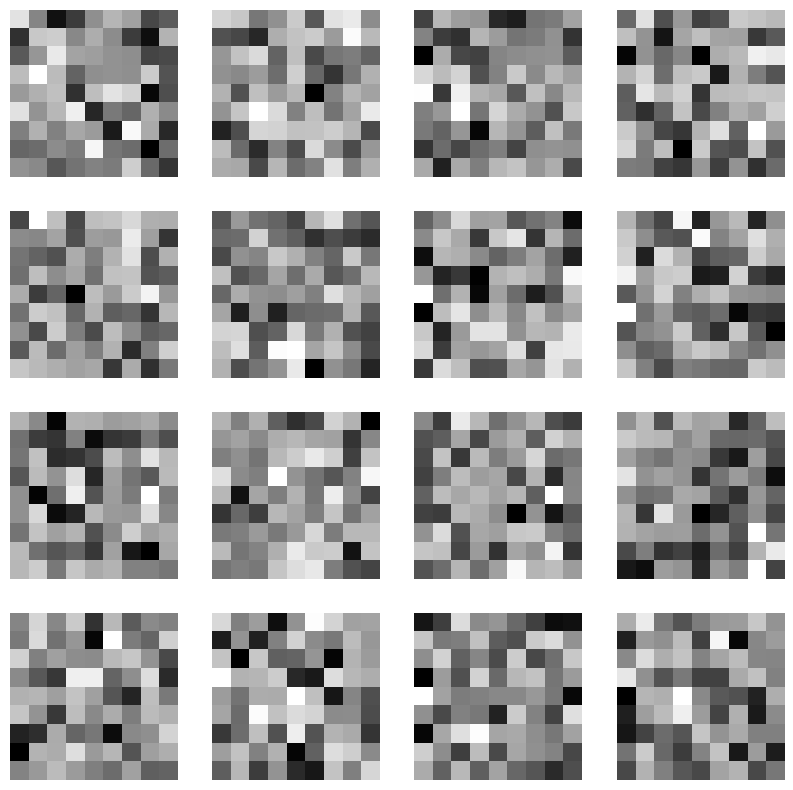

In [2]:
# Step 1: Build the model
# Instantiate the GaborLayer
gabor_layer = GaborLayer(filters=16, kernel_size=(9, 9))
# Input shape for the model (adjust according to your data)
input_shape = (None, 256, 256, 3)
# Build the model
gabor_layer.build(input_shape)

# Step 2: Get the kernels from the model's weights
kernels_real_value, kernels_imag_value = gabor_layer.get_weights()

# Step 3: Display the kernels
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.ravel()

for i in range(gabor_layer.filters):
    kernel_real = kernels_real_value[:, :, :, i]
    kernel_imag = kernels_imag_value[:, :, :, i]

    # Combine real and imaginary parts
    kernel = np.sqrt(np.square(kernel_real) + np.square(kernel_imag))

    axs[i].imshow(kernel[:, :, 0], cmap='gray')
    axs[i].axis('off')

plt.show()
